In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md

In [2]:
# traj_nums = [1,3,4,6,7,8,9,10]
traj_nums = [4]

In [3]:
trajs = {}
for i in traj_nums:
    df = pd.read_csv('data/'+str(i)+'_mw_disp_full.csv')
    pdb = md.load('data/{}.pdb'.format(i))
    xyz = df.values.reshape(-1, 1, 3)
    time = np.arange(xyz.shape[0])*0.1 # time in picoseconds
    traj = md.Trajectory(xyz=xyz, time = time, 
                         topology=pdb.topology, 
                         unitcell_angles=np.repeat(pdb.unitcell_angles, time.shape[0], axis=0), 
                         unitcell_lengths=np.repeat(pdb.unitcell_lengths, time.shape[0], axis=0))
    trajs[i]=traj

In [4]:
def plot_sample(ax, fig, traj, frac=0.01, plot_cbar=False):
    xyz = traj[::int(1/frac)].xyz
    t = traj[::int(1/frac)].time  
    c = ax.scatter(xs=xyz[:, 0, 0], ys = xyz[:, 0, 1], zs = xyz[:, 0, 2], c=t)
    if plot_cbar:
        fig.colorbar(c)
    return ax, fig

## Visualize all trajectories

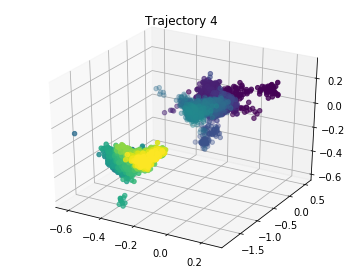

In [5]:
fig = plt.figure(figsize=(10,15))

for i, traj in enumerate(trajs.values()):
    ax = fig.add_subplot(4,2,i+1,projection='3d')

    plot_sample(ax, fig,traj, frac=0.001)
    ax.set_title('Trajectory {}'.format(traj_nums[i]))
plt.tight_layout()


## Attempt to undo PBCs

Let's focus on traj four first as this should be easy to see whether it has worked.

First get the trajectory and the unitcell lengths. 

In [94]:
# traj = trajs[4]
xyz = traj.xyz.reshape(-1, 3)
box_l = traj.unitcell_lengths
box_l[:10]

array([[2.3741, 2.3741, 2.3741],
       [2.3741, 2.3741, 2.3741],
       [2.3741, 2.3741, 2.3741],
       [2.3741, 2.3741, 2.3741],
       [2.3741, 2.3741, 2.3741],
       [2.3741, 2.3741, 2.3741],
       [2.3741, 2.3741, 2.3741],
       [2.3741, 2.3741, 2.3741],
       [2.3741, 2.3741, 2.3741],
       [2.3741, 2.3741, 2.3741]], dtype=float32)

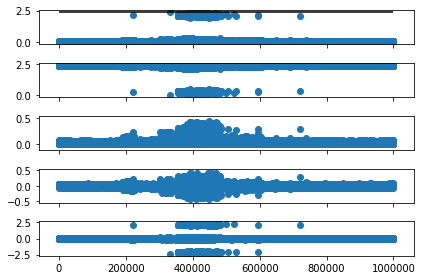

In [165]:
dxyz = xyz[1:,:] - xyz[:-1,:]
fig, axes = plt.subplots(5, sharex=True)
axes[0].scatter(traj.time[::100], np.abs(dxyz[::100,1]))
axes[0].hlines(box_l[0,1], 0, 1e6)
axes[1].scatter(traj.time[::100],box_l[0,1]-  np.abs(dxyz[::100,1]))
axes[2].scatter(traj.time[::100],np.minimum(box_l[0,1]-  np.abs(dxyz[::100,1]), np.abs(dxyz[::100,1])))
axes[3].scatter(traj.time[::100],np.sign(dxyz[::100,1])*np.minimum(box_l[0,1]-  np.abs(dxyz[::100,1]), np.abs(dxyz[::100,1])))
axes[4].scatter(traj.time[::100],dxyz[::100,1])
plt.tight_layout()
# np.where(np.abs(dxyz)>box_l[1:])

In [176]:
box_l = np.array([2.5, 2.5, 2.5])

In [177]:
xyz_no_pbc = np.copy(xyz)
# xyz_no_pbc[0] = xyz[0]
for i in range(1,xyz_no_pbc.shape[0]):
    dxyz = xyz_no_pbc[i] - xyz_no_pbc[i-1]
#     print(np.minimum(box_l[i]-np.abs(dxyz), np.abs(dxyz)))
    new_dxyz = np.minimum(box_l-np.abs(dxyz), np.abs(dxyz))
    jumped = (np.abs(dxyz) > box_l/2)
    
    xyz_no_pbc[i] = xyz_no_pbc[i-1] + dxyz*((~jumped)*1) - (jumped*1)*np.sign(dxyz)*new_dxyz
    
    

In [178]:
new_traj = md.Trajectory(xyz=xyz_no_pbc.reshape(-1, 1, 3), topology=traj.top, time=traj.time)



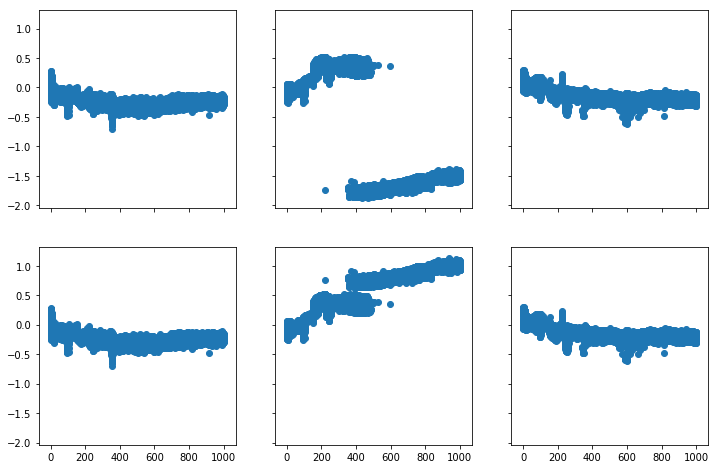

In [179]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
trajs = [traj, new_traj]
for i in range(2):
    for j in range(3):
        axes[i,j].scatter(trajs[i].time[::100]/1000, trajs[i].xyz[::100, 0, j])

        

In [164]:
new_traj.save_hdf5('data/traj_4_no_jumps.h5', force_overwrite=True)

